In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import gensim
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python import keras
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

In [2]:
DATA_PATH = './../data/Brown_tagged_train.txt'


In [3]:
with open(DATA_PATH, 'r') as f:
    data = f.read().splitlines()
data = np.array(data)

In [4]:
def split_Xy(test_Xy):
    """
    test_Xy: List of list of tokens and tags
    Returns: List of tokens and list of tags
    """
    test_y = []
    test_X = []

    for sent in test_Xy:
        tagged_sent = sent.split(' ')
        sent_y = []
        sent_X = []

        for word in tagged_sent:
            if word == "":
                continue
            actual_word, tag = split_tag_word(word)
            sent_X.append(actual_word)
            sent_y.append(tag)

        test_y.append(sent_y)
        test_X.append(sent_X)

    return test_X, test_y

In [5]:
def split_tag_word(inp):
    """
    Returns word, tag for the given input
    """
    arr = inp.split('/')
    tag = arr[-1]
    del arr[-1]
    word = '/'.join(arr)
    return word, tag


In [6]:
def preprocessData(trainSents, trainSentTags):
    uniqueWords = set()
    for sent in trainSents:
        for word in sent:
            uniqueWords.add(word)

    uniqueTags = set()
    for sent in trainSentTags:
        for tag in sent:
            uniqueTags.add(tag)

    tagIndex = {}
    idx = 0
    for i in uniqueTags:
        tagIndex[i] = idx
        idx += 1

    wordIndex = {}
    idx = 0
    for i in uniqueWords:
        wordIndex[i] = idx
        idx += 1

    # trainSentsText = trainSents.copy()
    # trainTagsText = trainSentTags.copy()
    trainSents[0]
    wordTokenize = Tokenizer()
    wordTokenize.fit_on_texts(trainSents)
    trainSents = wordTokenize.texts_to_sequences(trainSents)
    paddedTrainSents = pad_sequences(
        trainSents, maxlen=387, padding='pre', truncating='post')
    tagTokenize = Tokenizer()
    tagTokenize.fit_on_texts(trainSentTags)
    trainSentTags = tagTokenize.texts_to_sequences(trainSentTags)
    paddedTrainSentTags = pad_sequences(
        trainSentTags, maxlen=387, padding='pre', truncating='post')

    oneHotEncodedTrainSentTags = to_categorical(
        paddedTrainSentTags, num_classes=None, dtype='float32')

    return paddedTrainSents, oneHotEncodedTrainSentTags, tagIndex, wordIndex, trainSents, wordTokenize, tagTokenize


In [7]:
gloveEmbeddings = {} 
f = open('../data/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    gloveEmbeddings[word] = coefs
f.close()

In [8]:
def makeModel(trainSents, trainSentTags, testSents, testSentTags):
    trainPaddedSents, trainOneHotEncodedTags, trainTagIndex, trainWordIndex, trainSents, trainWordTokenizer, traintagWordTokenizer = preprocessData(
        trainSents, trainSentTags)
    testPaddedSents, testOneHotEncodedTags, testTagIndex, testWordIndex, testSents, testWordTokenizer, testTagWordTokenizer = preprocessData(
        testSents, testSentTags)
    w2vgensim = gensim.models.word2vec.Word2Vec(
        trainSents, vector_size=300, min_count=1, window=5)
    embeddings = np.zeros((len(trainWordTokenizer.word_index) + 1, 300))
    wordIndices = trainWordTokenizer.word_index
    for word, index in wordIndices.items():
        try:
            embeddings[index, :] = gloveEmbeddings[word]
        except:
            embeddings[index, :] = np.random.uniform(-0.25, 0.25, 300)

    mlp = keras.Sequential()
    mlp.add(keras.layers.Embedding(len(trainWordTokenizer.word_index) + 1,
                                   300, weights=[embeddings], input_length=387, trainable=True))
    mlp.add((keras.layers.Dense(100, activation='relu')))
    mlp.add((keras.layers.Dense(13, activation='softmax')))
    mlp.compile(loss='mean_squared_error',
                optimizer='adam', metrics=['accuracy'])
    mlp.summary()
    mlp.fit(trainPaddedSents, trainOneHotEncodedTags, batch_size=128,
            epochs=2, validation_data=(testPaddedSents, testOneHotEncodedTags))
    return mlp, traintagWordTokenizer, testTagWordTokenizer, trainPaddedSents, trainOneHotEncodedTags, testPaddedSents, testOneHotEncodedTags


In [9]:
def evaluate_model(tags, preds, test_y, to_print=False):

    flat_tags = [item for elem in test_y for item in elem]
    flat_preds = [item for elem in preds for item in elem]

    accuracy = accuracy_score(flat_tags, flat_preds)
    precision = precision_score(flat_tags, flat_preds, average='weighted')
    recall = recall_score(flat_tags, flat_preds, average='weighted')
    f1_score = (2 * precision * recall) / (precision + recall)

    tagwise_precision = precision_score(
        flat_tags, flat_preds, labels=tags, pos_label=None, average=None)
    tagwise_recall = recall_score(
        flat_tags, flat_preds, labels=tags, pos_label=None, average=None)
    tagwise_f1 = (2 * tagwise_precision * tagwise_recall) / \
        (tagwise_precision + tagwise_recall)

    cm = confusion_matrix(flat_tags, flat_preds)

    if to_print:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score", f1_score)
        print("Tagwise Precision: ", tagwise_precision)
        print("Tagwise Recall: ", tagwise_recall)
        print("Tagwise F1 score: ", tagwise_f1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags)
        disp.plot()
        plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1-score": f1_score,
        "cm": cm,
        "tagwise_precision": tagwise_precision,
        "tagwise_recall": tagwise_recall,
        "tagwise_f1": tagwise_f1
    }


In [10]:
def KFoldMLPGlove():
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    metrics = []
    unique_tags = []
    for train_index, test_index in kf.split(data):
        train_Xy, test_Xy = data[train_index], data[test_index]
        train_X, train_y = split_Xy(train_Xy)
        test_X, test_y = split_Xy(test_Xy)
        mlp, trainTagWordTokenizer, testTagWordTokenizer, trainFinalSents, trainFinalTags, testFinalSents, testFinalTags= makeModel(train_X, train_y, test_X, test_y)
        pred = mlp.predict_classes(testFinalSents)
        reverseTagMapTest = dict(map(reversed, testTagWordTokenizer.word_index.items()))
        reverseTagMapTest[0] = 'pad'
        pred_final = np.array(list(map(lambda x: [reverseTagMapTest[i] for i in x], pred)))
        expected = testFinalTags
        actual_shaped = np.array(list(map(lambda x: [np.argmax(i) for i in x], expected)))
        actual_final = []
        for i in range(len(actual_shaped)):
            actual_final.append([j for j in actual_shaped[i] if j != 0])
        actual_test = list(map(lambda x: [reverseTagMapTest[i] for i in x], actual_final))
        pred_test = []
        for i in range(len(pred_final)):
            pred_test.append(pred_final[i][- len(actual_final[i]): ])
        tags = list(reverseTagMapTest.values())
        unique_tags = tags
        metrics.append(evaluate_model(tags, pred_test, actual_test, to_print=False))
        print("Average metrics: ")
    precision, recall, f1, accuracy = 0, 0, 0, 0
    tagwise_precision, tagwise_recall, tagwise_f1 = np.zeros(
        len(unique_tags)), np.zeros(len(unique_tags)), np.zeros(len(unique_tags))

    cm = np.zeros((len(unique_tags), len(unique_tags)))

    for metric_dict in metrics:
        accuracy += metric_dict['accuracy']
        precision += metric_dict["precision"]
        recall += metric_dict["recall"]
        f1 += metric_dict["f1-score"]
        tagwise_precision += metric_dict["tagwise_precision"]
        tagwise_recall += metric_dict["tagwise_recall"]
        tagwise_f1 += metric_dict["tagwise_f1"]
        cm += metric_dict["cm"]

    accuracy /= len(metrics)
    precision /= len(metrics)
    recall /= len(metrics)
    f1 /= len(metrics)
    tagwise_precision /= len(metrics)
    tagwise_recall /= len(metrics)
    tagwise_f1 /= len(metrics)
    cm /= len(metrics)
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=unique_tags)
    disp.plot()
    fig = disp.figure_
    fig.set_figwidth(12)
    fig.set_figheight(12)
    plt.show()

    return unique_tags, {
        "accuracy": accuracy, 
        "precision" : precision,
        "recall" : recall,
        "f1-score" : f1,
        "tagwise_precision" : tagwise_precision,
        "tagwise_recall" : tagwise_recall,
        "tagwise_f1" : tagwise_f1,
        "cm" : cm
    }


2021-10-31 23:39:58.530827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 387, 300)          7582800   
_________________________________________________________________
dense (Dense)                (None, 387, 100)          30100     
_________________________________________________________________
dense_1 (Dense)              (None, 387, 13)           1313      
Total params: 7,614,213
Trainable params: 7,614,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


2021-10-31 23:39:58.825670: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


144/144 [==============================] - 56s 384ms/step - loss: 0.0174 - accuracy: 0.9733 - val_loss: 0.0029 - val_accuracy: 0.9744
Epoch 2/2
144/144 [==============================] - 64s 444ms/step - loss: 8.0753e-04 - accuracy: 0.9931 - val_loss: 0.0034 - val_accuracy: 0.9738


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packa

Average metrics: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 387, 300)          7555200   
_________________________________________________________________
dense_2 (Dense)              (None, 387, 100)          30100     
_________________________________________________________________
dense_3 (Dense)              (None, 387, 13)           1313      
Total params: 7,586,613
Trainable params: 7,586,613
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
144/144 [==============================] - 66s 451ms/step - loss: 0.0179 - accuracy: 0.9754 - val_loss: 0.0028 - val_accuracy: 0.9757
Epoch 2/2
144/144 [==============================] - 50s 348ms/step - loss: 8.2531e-04 - accuracy: 0.9929 - val_loss: 0.0031 - val_accuracy: 0.9754


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packa

Average metrics: 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 387, 300)          7567200   
_________________________________________________________________
dense_4 (Dense)              (None, 387, 100)          30100     
_________________________________________________________________
dense_5 (Dense)              (None, 387, 13)           1313      
Total params: 7,598,613
Trainable params: 7,598,613
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
144/144 [==============================] - 55s 379ms/step - loss: 0.0181 - accuracy: 0.9760 - val_loss: 0.0029 - val_accuracy: 0.9747
Epoch 2/2
144/144 [==============================] - 56s 389ms/step - loss: 7.9636e-04 - accuracy: 0.9933 - val_loss: 0.0033 - val_accuracy: 0.9740


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packa

Average metrics: 


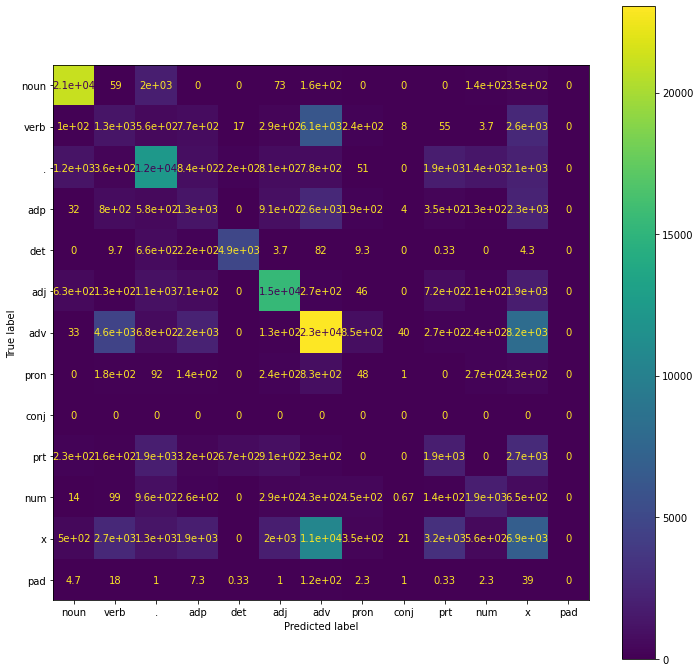

In [11]:
unique_tags, q2a_metrics = KFoldMLPGlove()


In [12]:
q2a_metrics["model_name"] = "MLP_Glove"
q2a_metrics["model_df_name"] = "mlp_glove"

In [13]:
with open("MLP_Glove_metrics.pkl", "wb") as f:
    import pickle
    pickle.dump(q2a_metrics, f)

In [14]:
def compare_metrics(metrics):
    """
    Metrics is an array of dictionaries with the following values:
        "accuracy": Accuracy for all tags,
        "precision": Precision for all tags
        "recall": Recall for all tags
        "f1-score": F1 score for all tags
        "cm": Confusion Matrix
        "tagwise_precision" : array of precision based on tag
        "tagwise_recall": array of recall based on tag
        "tagwise_f1": array of f1 scores based on tag,
        "model_name": Display Name of the model,
        "model_df_name": Name of the model to be stored in df columns 
    """
    num_models = len(metrics)
    metric_df = pd.DataFrame(
        {
            "model_name": [metrics[i]["model_name"] for i in range(num_models)],
            "accuracy": [metrics[i]["accuracy"] for i in range(num_models)],
            "precision": [metrics[i]["precision"] for i in range(num_models)],
            "recall": [metrics[i]["recall"] for i in range(num_models)],
            "f1-score": [metrics[i]["f1-score"] for i in range(num_models)]
        }
    )
    tagwise_metric_df = pd.DataFrame(
        {
            "tag": unique_tags
        }
    )
    for i in range(len(metrics)):
        tagwise_metric_df["precision_" + metrics[i]["model_df_name"]] = metrics[i]["tagwise_precision"]
    for i in range(len(metrics)):
        tagwise_metric_df["recall_" + metrics[i]["model_df_name"]] = metrics[i]["tagwise_recall"]
    for i in range(len(metrics)):
        tagwise_metric_df["tagwise_" + metrics[i]["model_df_name"]] = metrics[i]["tagwise_f1"]
    return metric_df, tagwise_metric_df

In [15]:
metric_df, tagwise_metric_df = compare_metrics([q2a_metrics])

In [16]:
metric_df

,model_name,accuracy,precision,recall,f1-score
0,MLP_Glove,0.498112,0.4882,0.498112,0.4931


In [17]:
tagwise_metric_df

,tag,precision_mlp_glove,recall_mlp_glove,tagwise_mlp_glove
0,noun,0.509375,0.572485,0.539088
1,verb,0.243592,0.229333,0.236246
2,.,0.883890,0.885232,0.884560
3,adp,0.557917,0.560500,0.558113
4,det,0.732804,0.731647,0.732216
5,adj,0.128369,0.109862,0.118386
6,adv,0.148526,0.141639,0.144969
7,pron,0.227456,0.211854,0.219360
8,conj,0.844441,0.832844,0.838572
9,prt,0.340549,0.363110,0.344169


In [18]:
with open('unique_tags_glovemlp.pkl', "wb") as f:
    import pickle
    pickle.dump(unique_tags, f)